In [1]:
!kaggle datasets download -d adityakadiwal/water-potability

  0%|                                                | 0.00/251k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 251k/251k [00:00<00:00, 3.77MB/s]


In [5]:
import torch
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import IPython
import os
import zipfile
import os
import cv2
import string
import torch.nn as nn
import plotly.express as px
import streamlit as st
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim as optim, functional as F
from torchvision.transforms import ToTensor
from torch.nn.utils.rnn import pad_sequence
from matplotlib import pyplot as plt, transforms

from sklearn.tree import export_graphviz
import pydot

dataset = pd.read_csv('water_potability.csv')

In [6]:
df = dataset.replace(to_replace=np.nan, value=0)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.000000,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,0.000000,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,0.000000,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


<AxesSubplot:>

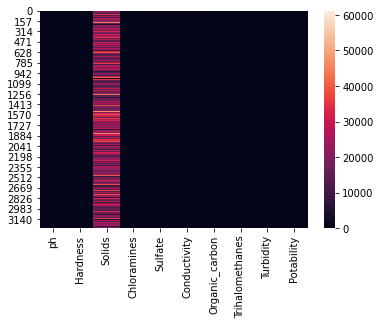

In [7]:
sns.heatmap(df)

In [8]:
def normalize(vals, iter):
    assert type(vals) is list
    mm = min(iter)
    mx = max(iter)

    return [(i-mm)/(mx-mm) for i in vals]


norm_df = pd.DataFrame()

for i in df.iloc[:-1]:
    list_data = df[i].to_list()
    avg = normalize([sum(list_data)/len(list_data)], list_data)
    norm_data = normalize(list_data, list_data)
    norm_df[i] = norm_data

norm_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.000000,0.571139,0.336096,0.543891,0.766098,0.669439,0.313402,0.701540,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.000000,0.719411,0.497319,0.454267,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.000000,0.414652,0.562017,0.535646,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.741920,0.317880,0.622089,0.809207,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.644732,0.379337,0.358555,0.258048,0.496327,0.0


In [9]:
print(norm_df.to_string())


            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability
0     0.000000  0.571139  0.336096     0.543891  0.766098      0.669439        0.313402         0.701540   0.286091         0.0
1     0.265434  0.297400  0.300611     0.491839  0.000000      0.719411        0.497319         0.454267   0.576793         0.0
2     0.578509  0.641311  0.321619     0.698543  0.000000      0.414652        0.562017         0.535646   0.303637         0.0
3     0.594055  0.605536  0.356244     0.603314  0.741920      0.317880        0.622089         0.809207   0.601015         0.0
4     0.649445  0.484851  0.289922     0.484900  0.644732      0.379337        0.358555         0.258048   0.496327         0.0
5     0.398863  0.511010  0.466746     0.563043  0.679122      0.173092        0.237538         0.442886   0.209814         0.0
6     0.730276  0.727768  0.466763     0.560580  0.818375      0.178659        0.444050         0.682287

In [10]:
norm_df = norm_df.sample(frac=1).reset_index(drop=True)
norm_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.581870,0.522142,0.331423,0.401170,0.000000,0.462435,0.276510,0.462610,0.704852,0.0
1,0.430090,0.687519,0.321366,0.566412,0.596508,0.233944,0.380521,0.597796,0.487435,0.0
2,0.563263,0.581770,0.197659,0.549954,0.708851,0.555868,0.453839,0.787316,0.752571,0.0
3,0.363574,0.460058,0.554510,0.500189,0.783035,0.603081,0.571171,0.391502,0.640738,0.0
4,0.663297,0.635599,0.196865,0.543081,0.690682,0.301222,0.458688,0.000000,0.716578,0.0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

x_train, x_test, y_train, y_test = train_test_split(norm_df.iloc[:,:-1], norm_df.iloc[:,-1])

assert (len(x_train))==(len(y_train))
assert (len(x_test))==(len(y_test))

rfregression = RandomForestRegressor(n_estimators = 1000)
rfregression.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [12]:
preds = rfregression.predict(x_test)
errors = abs(preds-y_test)

error_log = []
y_test_log = []
error_log.append(np.mean(errors))
y_test_log.append(np.mean(y_test))

acc = 100 - np.mean(errors)/np.mean(y_test)
print(f"Accuracy: {acc}%")

2021-11-27 13:30:15.489 INFO    numexpr.utils: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-11-27 13:30:15.489 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


Accuracy: 98.81259731543624%


In [42]:
print(x_test.iloc[0:1].shape)
print(x_test.iloc[0].shape)
a = np.array(x_test.iloc[0])
print(a.shape)
print(a.shape)




(1, 9)
(9,)
(9,)
(1, 9)


array([0.316])

In [20]:
from sklearn.tree import export_graphviz
import pydot
from subprocess import check_call

print(list(norm_df.iloc[:, :-1]))
tree = rfregression.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names=list(norm_df.iloc[:, :-1]), precision=1)
(graph,) = pydot.graph_from_dot_file('tree.dot')
check_call(['dot','-Tpng','/Users/devpatelio/Downloads/Coding/Python/indigenous_water_crisis/tree.dot','-o','output.png'])

importances = list(rfregression.feature_importances_)
feat_importance = [(norm_df, round(importance, 2)) for feature, importance in zip(list(norm_df.iloc[:, :-1]), importances)]
feat_importance = sorted(feat_importance, key=lambda x: x[1], reverse=True)

print(*[f"Name: {list(norm_df.iloc[:, :-1])[idx]}, Importance: {feat_importance[idx][-1]}" for idx in range(len(feat_importance))])

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
Name: ph, Importance: 0.12 Name: Hardness, Importance: 0.12 Name: Solids, Importance: 0.12 Name: Chloramines, Importance: 0.12 Name: Sulfate, Importance: 0.11 Name: Conductivity, Importance: 0.11 Name: Organic_carbon, Importance: 0.1 Name: Trihalomethanes, Importance: 0.1 Name: Turbidity, Importance: 0.1


In [63]:
import plotly.express as px
import streamlit as st

st.title("Posiedon Water Works")
st.markdown("Welcome to our attempt at making water quality transparent and easy to access for indigenous communities!")

st.header("Water Quality Metrics")
st.markdown("> We use key features like 'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', and 'Turbidity' to calculate the quality of water with our state-of-the-art hardware coupled with our global informatics system that allows communities to easily identify and access water quality readings and thus redirect water flow accordingly.'")

2021-11-26 23:47:36.858 WARNING root: 
  command:

    streamlit run /Users/devpatelio/miniconda3/lib/python3.8/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)